# Instructions

This is an imperfect implementation of ResNet configured to train with the CIFAR-10 dataset.

There are a few bugs and it should be able to reach a higher accuracy. See what you can do to fix it and write a few paragraphs about what you did.

# Imports

In [14]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import time
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files

print('TensorFlow Version:', tf.VERSION)
print('TensorFlow GPU:', tf.test.gpu_device_name())

ImportError: cannot import name pywrap_tensorflow

# Data

In [0]:
data_name = 'cifar-10-batches-bin'
data_dir = os.path.join('/content/.keras/datasets', data_name)
data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
tf.keras.utils.get_file(data_name, data_url, untar=True)

'/content/.keras/datasets/cifar-10-batches-bin'

# Inputs

In [0]:
def get_input_fn(filenames, batch_size, num_epochs, shuffle=False, augment=False):
    label_bytes = 1
    image_height = 32
    image_width = 32
    image_depth = 3
    image_bytes = image_height * image_width * image_depth
    record_bytes = label_bytes + image_bytes

    def _parse_record(value):
        raw_data = tf.decode_raw(value, tf.uint8)
        raw_data.set_shape([record_bytes])
        label = tf.squeeze(tf.cast(raw_data[:label_bytes], tf.int32), axis=0)
        depth_major = tf.reshape(
            raw_data[label_bytes:],
            [image_depth, image_height, image_width])
        image = tf.transpose(depth_major, [1, 2, 0])
        image = tf.to_float(image) / 255
        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
            image = tf.clip_by_value(image, 0.0, 1.0)
        features = {'image': image}
        labels = {'label': label}
        return features, labels
        
    def _input_fn():
        with tf.device('/cpu:0'):
            dataset = tf.data.FixedLengthRecordDataset(filenames, record_bytes)
            dataset = dataset.map(
                map_func=_parse_record,
                num_parallel_calls=4)
            if shuffle:
                dataset = dataset.shuffle(buffer_size=10000)
            dataset = dataset.batch(batch_size)
            dataset = dataset.prefetch(buffer_size=1000)
            dataset = dataset.repeat(num_epochs)
            iterator = dataset.make_one_shot_iterator()
            return iterator.get_next()
    return _input_fn

Images Min: 0.0 Max: 1.0


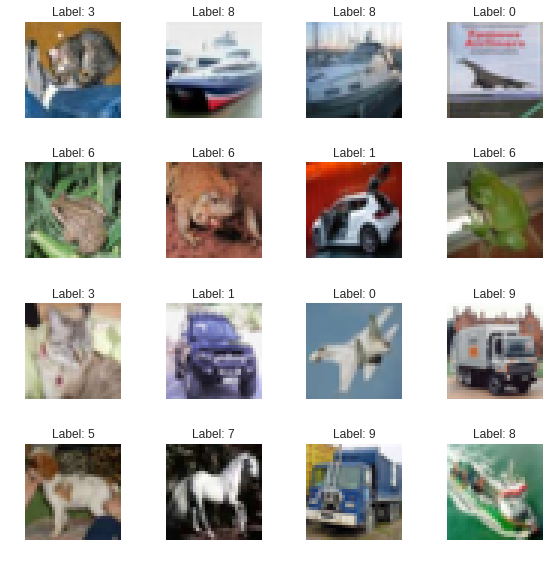

In [0]:
with tf.Session() as sess:
    input_fn = get_input_fn(
        filenames=[os.path.join(data_dir, 'test_batch.bin')],
        batch_size=16,
        num_epochs=1,
        shuffle=False,
        augment=False)

    features, labels = input_fn()
    image_batch, label_batch = sess.run([features['image'], labels['label']])
    print('Images Min:', image_batch.min(), 'Max:', image_batch.max())

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(image_batch[i])
        ax.grid(False)
        ax.axis('off')
        ax.set_title('Label: {}'.format(label_batch[i]))
    plt.tight_layout()

# Model

In [0]:
def batch_norm(inputs, momentum, training):
    return tf.layers.batch_normalization(
        inputs=inputs,
        scale=False,
        momentum=momentum,
        training=training,
        fused=True)

def resnet_block(inputs, filters, strides, training, params):
    kernel_initializer = tf.initializers.variance_scaling(scale=2.0)
    kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=params['l2_scale'])

    inputs = batch_norm(
        inputs=inputs,
        momentum=params['bn_momentum'],
        training=training)
    inputs = tf.nn.relu(inputs)

    hidden = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=3,
        strides=strides,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer,
        padding='same')

    hidden = batch_norm(
        inputs=hidden,
        momentum=params['bn_momentum'],
        training=training)
    hidden = tf.nn.relu(hidden)
    hidden = tf.layers.conv2d(
        inputs=hidden,
        filters=filters,
        kernel_size=3,
        strides=1,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer,
        padding='same')

    inputs_padded = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=1,
        strides=strides,
        use_bias=False,
        padding='same',
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer)
    hidden = hidden + inputs_padded
    return hidden

def resnet_layer(inputs, filters, strides, training, params):
    hidden = resnet_block(inputs, filters, strides, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    hidden = resnet_block(hidden, filters, 1, training, params)
    return hidden

In [0]:
def model_fn(features, labels, mode, params):
    kernel_initializer = tf.initializers.variance_scaling(scale=2.0)
    kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=params['l2_scale'])
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    num_classes = 10

    inputs = features['image'] * 2 - 1

    hidden = tf.layers.conv2d(
        inputs=inputs,
        filters=16,
        kernel_size=3,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer,
        padding='same')

    hidden = resnet_layer(hidden, filters=16, strides=2, training=training, params=params)
    hidden = resnet_layer(hidden, filters=32, strides=1, training=training, params=params)
    hidden = resnet_layer(hidden, filters=64, strides=1, training=training, params=params)

    hidden = batch_norm(
        inputs=hidden,
        momentum=params['bn_momentum'],
        training=training)
    hidden = tf.nn.relu(hidden)

    hidden = tf.reduce_mean(hidden, axis=[1, 2])

    logits = tf.layers.dense(
        inputs=hidden,
        units=num_classes,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer)

    outputs = tf.nn.softmax(logits)
    prediction = tf.argmax(outputs, axis=-1)
    
    predictions = {
        'prediction': prediction
    }

    loss = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels=labels['label'],
            logits=logits)
        loss = tf.losses.get_total_loss()
        
    train_op = None
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.piecewise_constant(
            boundaries=params['lr_boundaries'],
            values=params['lr_values'],
            x=global_step)

        optimizer = tf.train.MomentumOptimizer(
            learning_rate=learning_rate,
            momentum=params['momentum'])
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            train_op = optimizer.minimize(
                global_step=global_step,
                loss=loss)

    eval_metric_ops = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(
                predictions=predictions['prediction'],
                labels=labels['label'])
        }

    estimator_spec = tf.estimator.EstimatorSpec(
        loss=loss,
        mode=mode,
        train_op=train_op,
        predictions=predictions,
        eval_metric_ops=eval_metric_ops)
    return estimator_spec

# Training

In [0]:
max_steps_train = 3000
batch_size = 256
model_dir = os.path.join('jobs/', str(int(time.time())))
print('Model Directory:', model_dir)

params = {
    'l2_scale': 1e-4,
    'lr_values': [1e-1, 1e-2, 1e-3],
    'lr_boundaries': [max_steps_train // 3, max_steps_train // 3 * 2],
    'bn_momentum': 0.99,
    'momentum': 0.9,
}
print('Hyperparameters:', params)

config = tf.estimator.RunConfig(
    save_checkpoints_steps=1000,
    save_checkpoints_secs=None,
    save_summary_steps=100)

tf.logging.set_verbosity(tf.logging.INFO)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    model_dir=model_dir,
    config=config,
    params=params)

filenames_train = [
    os.path.join(data_dir, 'data_batch_{}.bin'.format(i))
    for i in xrange(1, 6)]
filenames_eval = [os.path.join(data_dir, 'test_batch.bin')]

input_fn_train = get_input_fn(
    filenames=filenames_train,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True,
    augment=True)
input_fn_eval = get_input_fn(
    filenames=filenames_eval,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False,
    augment=False)

train_spec = tf.estimator.TrainSpec(
    input_fn=input_fn_train,
    max_steps=max_steps_train)
eval_spec = tf.estimator.EvalSpec(
    input_fn=input_fn_eval,
    start_delay_secs=0,
    throttle_secs=60 * 5)

tf.estimator.train_and_evaluate(
    train_spec=train_spec,
    eval_spec=eval_spec,
    estimator=estimator)

Model Directory: jobs/1522769570
Hyperparameters: {'lr_boundaries': [1000, 2000], 'momentum': 0.9, 'bn_momentum': 0.99, 'l2_scale': 0.0001, 'lr_values': [0.1, 0.01, 0.001]}
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1e483364d0>, '_evaluation_master': '', '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'jobs/1522769570', '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 300 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Cal

# Download

You can download the model directory for inspection via TensorBoard.

In [2]:
model_tarball = model_dir + '.tar.gz'
with tarfile.open(model_tarball, "w:gz") as tar:
    tar.add(model_dir, arcname=os.path.basename(model_dir))
files.download(model_tarball)

NameError: name 'model_dir' is not defined